In [116]:
import os
import tarfile
from six.moves import urllib

In [117]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH=os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [118]:
import pandas as pd
def load_housing_data(housing_path="https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/"):
  csv_path=os.path.join(housing_path,"housing.csv")
  return pd.read_csv(csv_path)

In [119]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [120]:
import matplotlib.pyplot as plt

In [121]:
import numpy as np
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [122]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


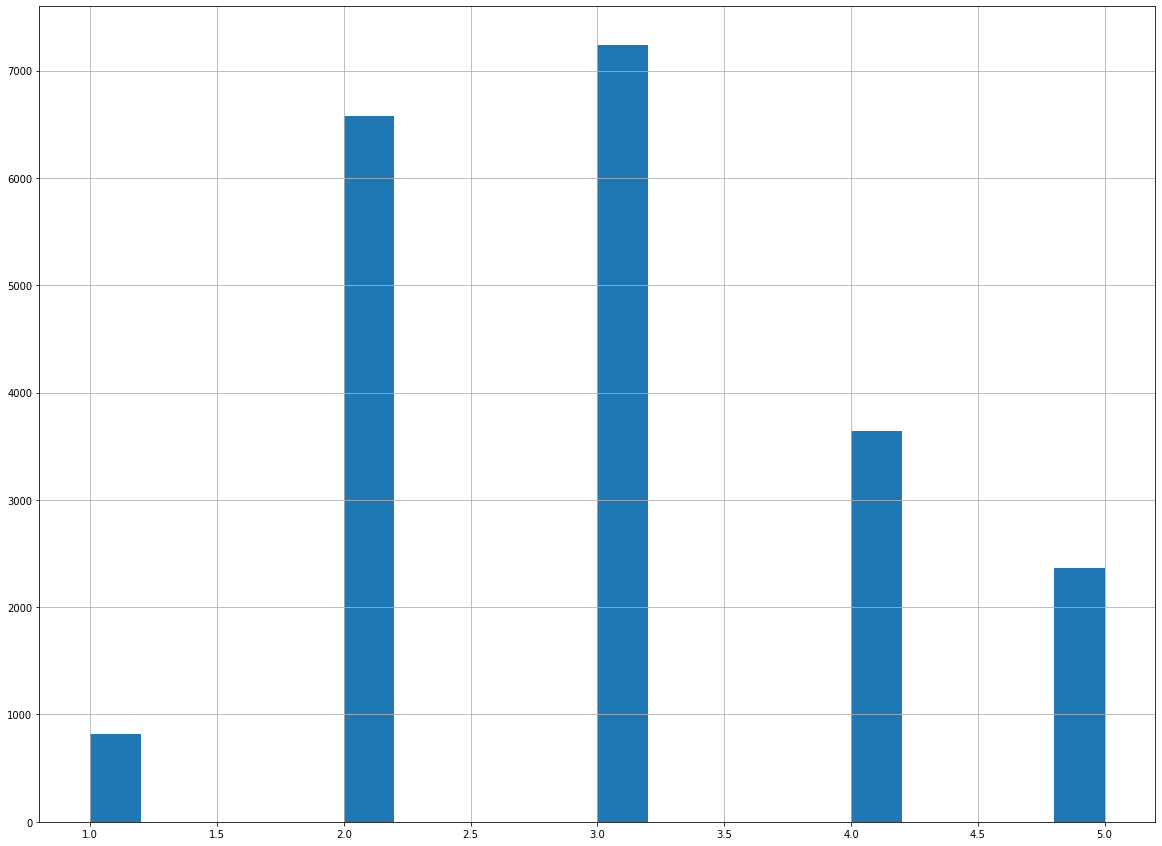

In [123]:
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5,5.0,inplace=True)
housing["income_cat"].hist(bins=20,figsize=(20,15))
plt.show()

In [124]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]   

In [125]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

In [126]:
housing=strat_train_set.copy()

In [127]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [128]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [129]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

**housing.dropna(subset=["total_bedrooms"]) 
# option 1
housing.drop("total_bedrooms", axis=1) 
# option 2
median = housing["total_bedrooms"].median()
 # option 3
housing["total_bedrooms"].fillna(median, inplace=True)**

In [144]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy="median")
housing_num=housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [145]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [146]:
x=imputer.transform(housing_num)
housing_tr=pd.DataFrame(x,columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [147]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
housing_cat=housing["ocean_proximity"]
housing_cat_encoded=encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [148]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [149]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Above 2 steps could be done in a sigle function

In [150]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [151]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
   def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
      self.add_bedrooms_per_room = add_bedrooms_per_room
   def fit(self, X, y=None):
      return self # nothing else to do
   def transform(self, X, y=None):
      rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
      population_per_household = X[:, population_ix] / X[:, household_ix]
      if self.add_bedrooms_per_room:
         bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
         return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
      else:
         return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [152]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [153]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

There's no particular method to transform pipeline fit to pandas dataframe so we have to write custom transformer to this task

In [154]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
   def __init__(self, attribute_names):
      self.attribute_names = attribute_names
   def fit(self, X, y=None):
      return self
   def transform(self, X):
      return X[self.attribute_names].values

In [155]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
('selector', DataFrameSelector(num_attribs)),
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
('selector', DataFrameSelector(cat_attribs)),
('label_binarizer', LabelBinarizer()),
])

In [156]:
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
("num_pipeline", num_pipeline),
("cat_pipeline", cat_pipeline),
])

In [157]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

TypeError: ignored